# Machine Learning Model Development
## Predicting (Claim Injury Type)

## 1. Importing Required Libraries

In [4]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFE

from sklearn.model_selection import StratifiedKFold

# embedded methods
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder

#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, f1_score

#from utils_train import *
from utils import *
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [6]:
import ray
ray.init()

2024-12-15 03:19:44,521	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-15 03:19:45,308	INFO worker.py:1821 -- Started a local Ray instance.


Python version:,3.12.7
Ray version:,2.40.0


## 2. Loading and Exploring the Dataset

In [9]:
# Activate sections if features and target analises are needed
run_plot_target_analysis = False  # Set to True when you want to run this cell
run_plot_features_analysis = False  # Set to True when you want to run this cell
run_plot_features_importance_analysis = True  # Set to True when you want to run this cell

In [11]:
numerical_features = [
    "Age at Injury",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Number of Dependents",
    "Years Past Accident",
    "Assembly Years past Accident",
    "Industry Code",
    "Birth Year",
    "Average Weekly Wage",
    "IME-4 Count"
]

categorical_features = [
    "Carrier Name",
    "Carrier Type",
    "County of Injury",
    "District Name",
    "Gender",
    "Medical Fee Region",
    "Zip Code"
]

binary_features = [
    "Alternative Dispute Resolution",
    "Attorney/Representative",
    "COVID-19 Indicator",
    "First Hearing Date Occurred",
    "C-2 Date Occurred",
    "C-3 Date Occurred"
]


In [13]:
reference_date = pd.to_datetime("2023-01-01")

In [15]:
# Prepare data to be included in the model to be used as a mtraining set
train_df = pd.read_csv("./data/train_data_after_EDA.csv", index_col="Claim Identifier")

In [16]:
# Target column: Data target distribution interpretation
categorical_target = "Claim Injury Type" 

if run_plot_target_analysis:
    train_df[categorical_target].value_counts().plot(kind='bar', color='skyblue')
    plt.title("Target Distribution: Claim Injury Type")
    plt.xlabel("Claim Injury Type (Classes)")
    plt.ylabel("Frequency")
    plt.show()

### 2.1. Draw Features Relation Plots with Target
### Exploring Relationships Between Features and Target
- In this section, we visualize how different features relate to the target variable.
- The plots help identify patterns, trends, or potential transformations needed for better modeling.
- For numerical features, scatter plots or box plots are used.
- For categorical features, bar plots or count plots are used.

#### Numerical Features
- Visualized using scatter plots and box plots.
- These plots show how numerical features vary with the target.

In [21]:
# Example: Scatterplots for numerical features
if run_plot_features_analysis:
    for feature in numerical_features:
        sns.scatterplot(data=train_df, x=feature, y=train_df[categorical_target])
        plt.title(f"{feature} vs. Claim Injury Type")
        plt.xlabel(feature)
        plt.ylabel(categorical_target)
        plt.show()

In [23]:
if run_plot_features_analysis:
    # Generate boxplots for each numerical feature grouped by the target
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=train_df, x=categorical_target, y=feature, palette="Set2")
        plt.title(f"Boxplot of {feature} by {categorical_target}")
        plt.xlabel(categorical_target)
        plt.ylabel(feature)
        plt.show()

#### Categorical Features
- Visualized using bar plots or count plots.
- These plots show the distribution of the target variable across different categories.

In [26]:
if run_plot_features_analysis:
    for cat_feature in categorical_features:
        sns.boxplot(data=train_df, x=cat_feature, y=categorical_target)
        plt.title(f"{categorical_target} by {cat_feature}")
        plt.xlabel(cat_feature)
        plt.ylabel(categorical_target)
        plt.show()

In [28]:
for col in numerical_features+categorical_features+binary_features:
    if col not in train_df.columns:
        print(col)
print("-------")
for col in train_df.columns:
    if col not in numerical_features+categorical_features+binary_features:
        print(col)

-------
Accident Date
Claim Injury Type


## 3. Data Preprocessing
- Handling Missing Values
- Encoding Categorical Variables

In [31]:
# Removing NA values
train_df.dropna(subset = ["Accident Date", "Age at Injury","Birth Year","Years Past Accident","Assembly Years past Accident"], inplace=True)

In [33]:
# Convert date to a numerical representative value
train_df["Accident_Days"] = (pd.to_datetime(train_df["Accident Date"]) - reference_date).dt.days

In [35]:
train_df = train_df.drop(columns=["Accident Date"])

In [37]:
train_df.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,...,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Years Past Accident,First Hearing Date Occurred,C-2 Date Occurred,C-3 Date Occurred,Assembly Years past Accident,Accident_Days
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5393875,31.0,0,0,0.00,1988.0,0.022195,0,1,0.005846,0,...,10.0,62.0,0.000939,1.0,-3.986311,0,1,0,0.005476,-1098
5393091,46.0,0,1,1745.93,1973.0,0.004988,0,3,0.001323,0,...,49.0,38.0,0.000354,4.0,-4.320329,1,1,1,0.339493,-1220
5393889,40.0,0,0,1434.80,1979.0,0.015894,0,3,0.030402,0,...,7.0,10.0,0.000899,6.0,-4.052019,0,1,0,0.071184,-1122
5393887,61.0,0,0,NaN,1958.0,0.193647,1,1,0.020094,0,...,43.0,36.0,0.003076,1.0,-3.986311,0,1,0,0.005476,-1098
5393863,67.0,0,0,0.00,1952.0,0.025027,0,2,0.105272,0,...,10.0,38.0,0.003226,5.0,-3.997262,0,1,0,0.016427,-1102


## 4. Data Visualization and Correlation Analysis

### Correlation Matrix

#### Why Is It Useful?
- A correlation matrix shows the relationships between numerical features and the target variable.
- It helps identify:
  - Features that are strongly related to the target (important for predictions).
  - Features that are highly correlated with each other (potential redundancy).

#### How to Interpret?
- Correlation values range from **-1** to **1**:
  - \( r = 1 \): Perfect positive relationship (both increase together).
  - \( r = -1 \): Perfect negative relationship (one increases, the other decreases).
  - \( r = 0 \): No relationship.

- **Strong correlation** (e.g., \( |r| > 0.7 \)): Indicates a strong relationship.
- **Weak correlation** (\( |r| < 0.3 \)): May not be significant.

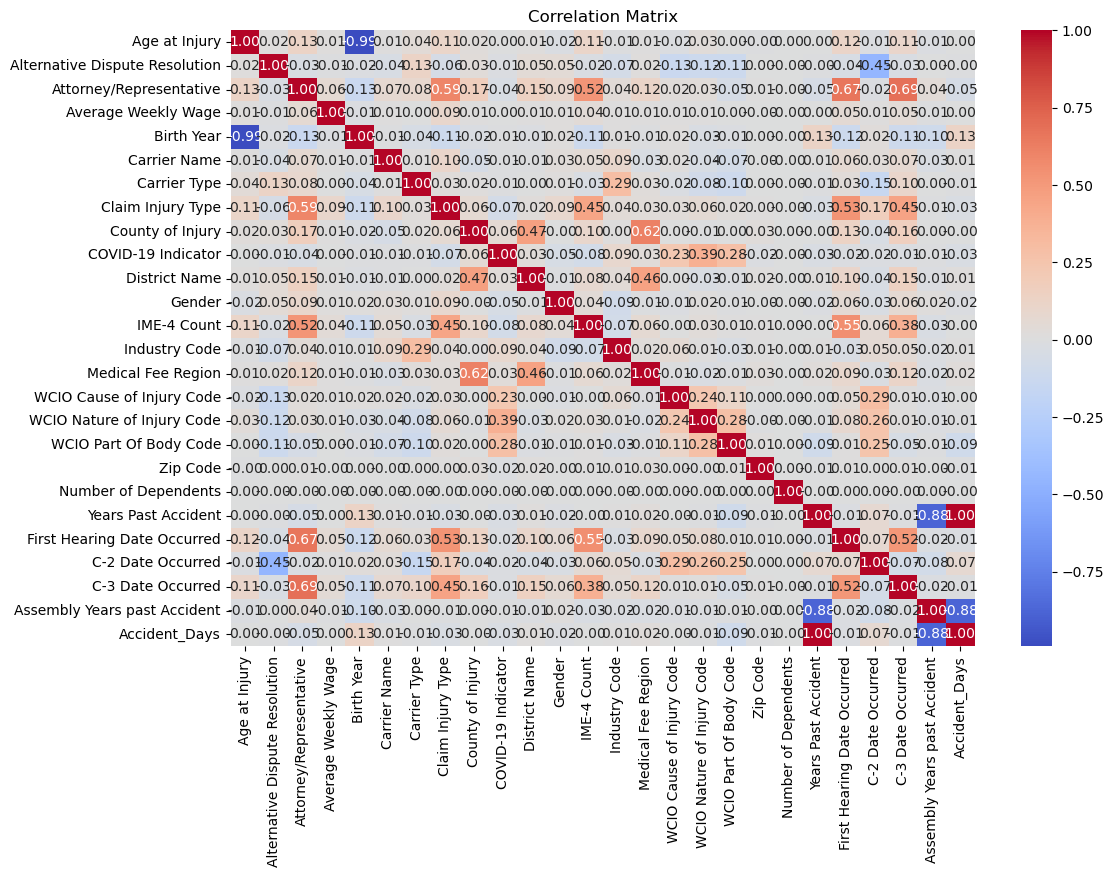

In [40]:
# Compute and visualize correlation matrix
correlation_matrix = train_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## 5. Splitting Data into Training, Validation, and Test Sets

In [43]:
X = train_df.drop(["Claim Injury Type"], axis = 1)
y = train_df["Claim Injury Type"]

### 10% data split

In [46]:
 X, X_test, y, y_test = train_test_split(X,y, test_size = 0.1, random_state = None, stratify = y, shuffle = True)

### Train Val Split

In [49]:
 X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, random_state = None, stratify = y, shuffle = True)

### 5. Post-Split Preprocessing
#### 5.1 Imputing Missing Values
- Missing values in `X_train` and `X_val` for specific features (`Average Weekly Wage`, `Industry Code`) are imputed based on the percentage of missing data in `X_train`.
- Imputation ensures consistency between training and validation datasets.

In [52]:
to_impute = ["Average Weekly Wage","Industry Code"]
percent_missing = X_train[to_impute].isnull().mean()
imputation_value = percent_missing / ((1 / 0.97) - 1)
for col in to_impute:
        X_train[col].fillna(imputation_value[col], inplace=True)
        X_val[col].fillna(imputation_value[col], inplace=True)

#### 5.2 Drop Features, Scale Features
- Dropping Features simplifies the model and prevents overfitting.
- Scaling Features ensures numerical stability and faster convergence for many algorithms.

In [55]:
features_to_drop = ["Assembly Years past Accident","Birth Year", "Zip Code", "Number of Dependents", "Medical Fee Region"]

features_to_scale = [
    "Age at Injury",
    "WCIO Cause of Injury Code",
    "WCIO Nature of Injury Code",
    "WCIO Part Of Body Code",
    "Industry Code",
    "Average Weekly Wage",
    "IME-4 Count"
]

In [57]:
scaler = StandardScaler().fit(X_train[features_to_scale])
X_train[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])

In [59]:
X_train.drop(features_to_drop, axis=1, inplace=True)
X_val.drop(features_to_drop, axis=1, inplace=True)

## 6. Handling Class Imbalance
### Oversampling and Undersampling

In [62]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
# 'balanced': Balances the weights inversely proportional to class frequencies in the training data.
# np.unique(y_train): Ensures we only compute weights for classes present in the training data.
# y=y_train: The target variable for which we want to compute the weights.
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the computed class weights into a dictionary for easier access during model training
# {class_label: weight} mapping
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print the class weights to understand the balance adjustment
print(f"Class_weight_dict: {class_weight_dict}")

Class_weight_dict: {0: 6.612400027578599, 1: 0.246649615776317, 2: 1.035324502882311, 3: 0.48028529791773084, 4: 1.4721740398489547, 5: 16.873020760028147, 6: 737.7403846153846, 7: 152.23214285714286}


In [64]:
# Assuming `y_train` is your target variable
class_counts = pd.Series(y_train).value_counts()

# Display class distribution
print("Class Distribution:\n", class_counts)

Class Distribution:
 Claim Injury Type
1    194418
3     99843
2     46317
4     32573
0      7252
5      2842
7       315
6        65
Name: count, dtype: int64


In [66]:
total_samples = len(y_train)
class_proportions = class_counts / total_samples * 100

print("Class Proportions (%):\n", class_proportions)

Class Proportions (%):
 Claim Injury Type
1    50.679179
3    26.026197
2    12.073509
4     8.490844
0     1.890388
5     0.740828
7     0.082111
6     0.016944
Name: count, dtype: float64


- Class Dominance: Without balancing, the model will likely favor the majority classes (1 and 3) and perform poorly on minority classes (0, 5, 6, 7).
- Learning Challenges for Minority Classes: With such small samples, the model might not have enough information to learn patterns for underrepresented classes (6 and 7).

### Oversampling Techniques Summary

#### **1. SMOTE (Synthetic Minority Oversampling Technique)**
- **What it does**: Generates synthetic samples for minority classes by interpolating between existing samples.
- **Pros**: Balances classes effectively, widely used.
- **Cons**: Can generate noisy samples near class boundaries.

#### **2. SMOTEENN (SMOTE + Edited Nearest Neighbors)**
- **What it does**: Combines SMOTE (oversampling) with ENN (undersampling by removing noisy samples).
- **Pros**: Improves data quality by removing misclassified or overlapping samples.
- **Cons**: Computationally expensive; may remove useful borderline samples.

#### **3. SMOTETomek (SMOTE + Tomek Links)**
- **What it does**: Combines SMOTE with Tomek Links (removes samples that are nearest neighbors but belong to different classes).
- **Pros**: Reduces overlap between classes, good for cleaning boundary noise.
- **Cons**: May not handle extremely imbalanced datasets well.

#### **4. ADASYN (Adaptive Synthetic Sampling)**
- **What it does**: Similar to SMOTE but generates more synthetic samples for harder-to-learn minority class regions.
- **Pros**: Focuses on difficult areas, improving model sensitivity for those.
- **Cons**: Can amplify noise and lead to overfitting.

### **For Your Dataset**
- **SMOTEENN**: Since your dataset has extreme imbalance and potential noise, SMOTEENN offers the best balance of oversampling and denoising.

#### **Notes**
- This step takes a while due to Smoteenn algorithm: ~15 mins

In [70]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

# Define the map of strategies
strategy_map = {
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
    "ADASYN": ADASYN(sampling_strategy='auto', random_state=42),
}

# Define the strategy to use
strategy = "SMOTE"  # Options: "SMOTE", "SMOTEENN", "ADASYN"

# Get the selected strategy from the map
if strategy in strategy_map:
    print(f"Starting with the choosen strategy: {strategy}")
    smote_strategy = strategy_map[strategy]
else:
    raise ValueError(f"Unknown strategy: {strategy}")

# Apply the selected strategy to training data
X_train_balanced, y_train_balanced = smote_strategy.fit_resample(X_train, y_train)

# Check class distribution after balancing
print("Class distribution after balancing:", Counter(y_train_balanced))

Starting with the choosen strategy: SMOTE
Class distribution after balancing: Counter({1: 194418, 4: 194418, 2: 194418, 5: 194418, 3: 194418, 0: 194418, 7: 194418, 6: 194418})


## 7. Model Training
### Training XGBoost Classifier

In [73]:
def XGB_GridSearch(config):
    """
    Trains and evaluates an XGBoost model using the provided configuration.
    """
    # Retrieve training data
    X_train = ray.get(X_train_ref)
    y_train = ray.get(y_train_ref)

    # Get the weight strategy
    weight_strategy = config.get("weight_strategy", "nothing")
    class_weight_dict = config.get("class_weight_dict", None)

    # Create the model
    if weight_strategy == "scale_pos_weight":
        class_counts = np.bincount(y_train)
        scale_pos_weight = class_counts[0] / class_counts[1] if len(class_counts) > 1 else 1
        model = xgb.XGBClassifier(
            max_depth=config["max_depth"],
            learning_rate=config["learning_rate"],
            n_estimators=config["n_estimators"],
            scale_pos_weight=scale_pos_weight
        )
    else:
        model = xgb.XGBClassifier(
            max_depth=config["max_depth"],
            learning_rate=config["learning_rate"],
            n_estimators=config["n_estimators"]
        )

    # Fit the model
    if weight_strategy == "sample_weight" and class_weight_dict:
        sample_weights = np.array([class_weight_dict[label] for label in y_train])
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    # Validate on X_val
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average="macro")

    # Report the F1 score using session.report
    session.report({
        "f1_score": f1,
    })

In [75]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

2024-12-15 03:20:18,526	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Why Hyperparameter Tuning Takes Longer?

1. **Large Search Space**:
   - Grid search or random search explores multiple combinations of hyperparameters.
   - Example: For 3 hyperparameters with 3 values each, the total combinations = 3 × 3 × 3 = 27.

2. **Model Training for Each Combination**:
   - For every hyperparameter combination, the model is trained and evaluated on the validation set.

3. **Complex Hyperparameters**:
   - Parameters like `n_estimators` (number of trees) or `max_depth` (tree complexity) increase training time.

4. **Iterative Process**:
   - Hyperparameter optimization tools may require multiple iterations to find the best configuration.

---

### **Notes to Reduce Runtime**
- **Reduce `n_estimators`**:
  - Fewer trees result in faster training but may slightly reduce model accuracy.
  - Start with a smaller number (e.g., `50` or `100`) and increase gradually as needed.

- **Use Random Search Instead of Grid Search**:
  - Randomly sample hyperparameter combinations instead of exhaustively testing all options.

- **Limit Search Space**:
  - Narrow the range of key hyperparameters like `max_depth` or `learning_rate` to reduce combinations.

- **Control `weight_strategy`**:
  - Choose between:
    - `"sample_weight"`: Applies instance-level weights to adjust for class imbalance. Slower but provides fine-grained control.
    - `"scale_pos_weight"`: Adjusts weights at the class level for binary classification. Faster, but not applicable to multiclass problems.
    - `"nothing"`: No weighting applied. Use this for simpler datasets or as a baseline.

- **Simplify `sample_weight` Calculations**:
  - Ensure `class_weight_dict` is precomputed and accessed efficiently to avoid recalculating during each trial.

---

### **Parameter Overview**

- **`sample_weight`**:
  - Applies weights to individual samples during training, based on a predefined `class_weight_dict`.
  - Slower because it involves per-sample computation during each training iteration.

- **`scale_pos_weight`**:
  - Adjusts class-level weights automatically for binary classification.
  - Faster because it is directly passed as a parameter to XGBoost, avoiding per-sample calculations.
  - **Note**: Not applicable for multiclass problems.

- **`weight_strategy`**:
  - Controls whether to use `sample_weight`, `scale_pos_weight`, or `"nothing"`.
  - Adding `"nothing"` as an option provides a baseline comparison without any weighting adjustments.

---

### Conclusion:
Hyperparameter tuning balances precision and time by exploring configurations that optimize model performance. To reduce runtime, prioritize reducing `n_estimators` and optimizing the search space.

In [78]:
# Training Types
# Without optimizating classes weight samples

# Fast run: Coarse search with fewer combinations
fast_search_space = {
    "max_depth": tune.grid_search([3, 7]),
    "learning_rate": tune.grid_search([0.1, 0.3]),
    "n_estimators": tune.grid_search([100, 200])
}

# Medium run: Balanced search with moderate combinations
medium_search_space = {
    "max_depth": tune.grid_search([3, 7, 9]),
    "learning_rate": tune.grid_search([0.01, 0.3, 0.5]),
    "n_estimators": tune.grid_search([100, 200, 500])
}

# Long run: Fine-grained search with detailed combinations
long_search_space = {
    "max_depth": tune.grid_search([3, 5, 7, 9, 11]),
    "learning_rate": tune.grid_search([0.01, 0.1, 0.3, 0.5]),
    "n_estimators": tune.grid_search([100, 200, 500, 1000])
}

# With optimizating classes weight samples
# Fast run: Coarse search with fewer combinations
fast_search_space_with_strategy = {
    "max_depth": tune.grid_search([3, 7]),
    "learning_rate": tune.grid_search([0.1, 0.3]),
    "n_estimators": tune.grid_search([100, 200]),
    "weight_strategy": tune.grid_search(["nothing", "sample_weight"])  # No scale_pos_weight in fast
}

# With optimizating classes weight samples
# Fast run: Coarse search with fewer combinations
fast_search_space_with_strategy_with_scale = {
    "max_depth": tune.grid_search([3, 7]),
    "learning_rate": tune.grid_search([0.1, 0.3]),
    "n_estimators": tune.grid_search([100, 200]),
    "weight_strategy": tune.grid_search(["nothing", "sample_weight", "scale_pos_weight"])  # No scale_pos_weight in fast
}

# Medium run: Balanced search with moderate combinations
medium_search_space_with_strategy = {
    "max_depth": tune.grid_search([3, 7, 9]),
    "learning_rate": tune.grid_search([0.01, 0.3, 0.5]),
    "n_estimators": tune.grid_search([100, 200, 500]),
    "weight_strategy": tune.grid_search(["nothing", "sample_weight", "scale_pos_weight"])
}

# Long run: Fine-grained search with detailed combinations
long_search_space_with_strategy = {
    "max_depth": tune.grid_search([3, 5, 7, 9, 11]),
    "learning_rate": tune.grid_search([0.01, 0.1, 0.3, 0.5]),
    "n_estimators": tune.grid_search([100, 200, 500, 1000]),
    "weight_strategy": tune.grid_search(["nothing", "sample_weight", "scale_pos_weight"])
}

# Map run_mode to corresponding search spaces
search_space_map = {
    "fast": fast_search_space,
    "medium": medium_search_space,
    "long": long_search_space,
    "fast_strategy": fast_search_space_with_strategy,
    "fast_strategy_with_scale": fast_search_space_with_strategy_with_scale,
    "medium_strategy": medium_search_space_with_strategy,
    "long_strategy": long_search_space_with_strategy
}


# Define the run mode: "fast", "medium", or "long", "fast_strategy", "medium_strategy", or "long_strategy"
run_mode = "fast" # default fast ~2mins 30secs, fast_strategy ~5mins, fast_strategy_with_scale ~7mins, medium_search_space_with_strategy takes ~3hours

# Retrieve the search space based on the selected run_mode
if run_mode not in search_space_map:
    raise ValueError(f"Unknown run mode: {run_mode}")
search_space = search_space_map[run_mode]

print(f"Using {run_mode} search space:")
print(search_space)

Using fast search space:
{'max_depth': {'grid_search': [3, 7]}, 'learning_rate': {'grid_search': [0.1, 0.3]}, 'n_estimators': {'grid_search': [100, 200]}}


In [80]:
X_train_ref = ray.put(X_train_balanced)
y_train_ref = ray.put(y_train_balanced)

# Execute the grid search
analysis = tune.run(
    XGB_GridSearch,
    config=search_space,
    resources_per_trial={"cpu": 1},  # Allocate 1 CPU per trial
    scheduler=ASHAScheduler(metric="f1_score", mode="max"),  # Manage trials efficiently
    verbose=1
)

(raylet) Warning: The actor ImplicitFunc is very large (46 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


2024-12-15 03:22:58,422	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/macuser/ray_results/XGB_GridSearch_2024-12-15_03-20-25' in 0.0035s.
2024-12-15 03:22:58,424	INFO tune.py:1041 -- Total run time: 153.13 seconds (153.07 seconds for the tuning loop).


## 8. Model Evaluation
### On Validation Set
### On Test Set

In [83]:
# Retrieve the best configuration
best_config = analysis.get_best_config(metric="f1_score", mode="max")
print(f"Best hyperparameters: {best_config}")

debug_info = [print(f"k: {k}, best_config_k: {best_config[k]}") for k in best_config]

best_weight_strategy = best_config.get("weight_strategy", "nothing")
print("Selected Weight Strategy:", best_weight_strategy)

Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.3, 'n_estimators': 100}
k: max_depth, best_config_k: 7
k: learning_rate, best_config_k: 0.3
k: n_estimators, best_config_k: 100
Selected Weight Strategy: nothing


In [85]:
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
X_test.drop(features_to_drop, axis=1, inplace=True)

In [87]:
# Override the strategy if needed; set to None to use the best_config value
override_strategy = None  # Options: "sample_weight", "scale_pos_weight", "nothing", or None

# Get the weight strategy: Use override_strategy if provided, otherwise use best_config
weight_strategy = override_strategy or best_config.get("weight_strategy", "nothing")

# Instantiate the model with the best configuration (excluding weight_strategy)
valid_xgb_params = ["max_depth", "learning_rate", "n_estimators"]
xgb_params = {k: best_config[k] for k in best_config if k in valid_xgb_params}
model = xgb.XGBClassifier(**xgb_params)

# Handle weight strategies
if weight_strategy == "scale_pos_weight":
    # Dynamically calculate scale_pos_weight
    class_counts = np.bincount(y_train)
    scale_pos_weight = class_counts[0] / class_counts[1] if len(class_counts) > 1 else 1
    model.set_params(scale_pos_weight=scale_pos_weight)

# Train the model
if weight_strategy == "sample_weight":
    if not class_weight_dict:
        raise ValueError("class_weight_dict is required for sample_weight strategy")
    sample_weights = np.array([class_weight_dict[label] for label in y_train])
    model.fit(X_train, y_train, sample_weight=sample_weights)
else:
    # Train without sample weights
    model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
# Evaluate the model
from sklearn.metrics import classification_report, f1_score

f1_test = f1_score(y_test, y_pred, average="macro")
print("F1 Score on Test Set:", f1_test)

F1 Score on Test Set: 0.4326229226744428


## 9. Feature Importance Analysis

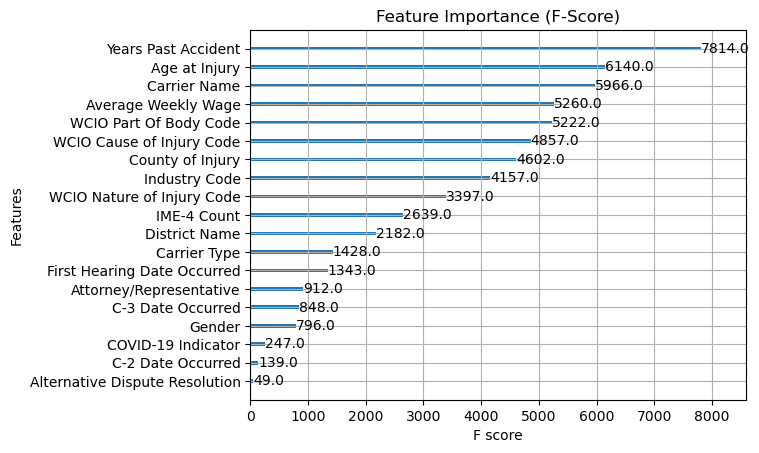

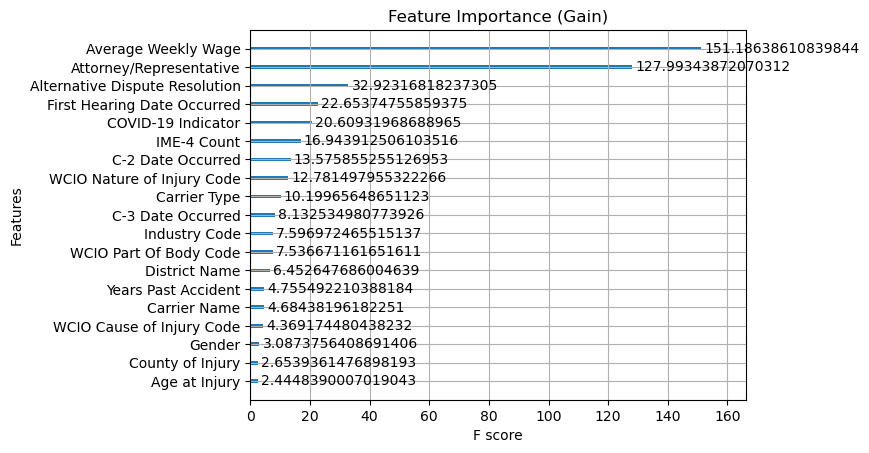

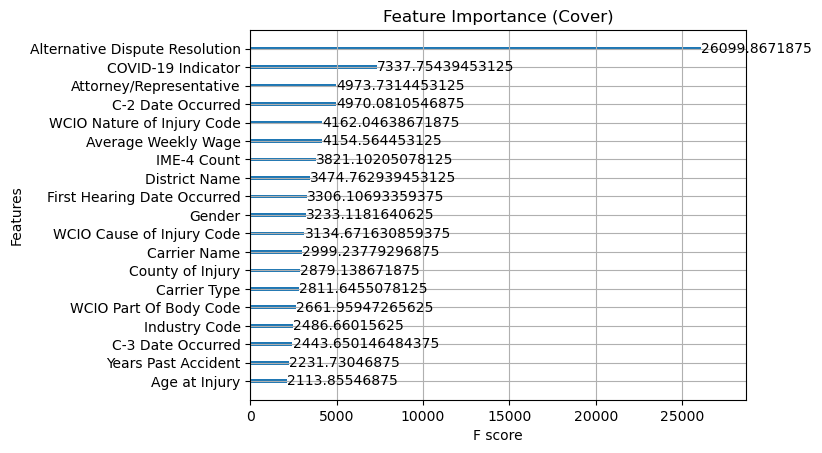

In [89]:
from xgboost import plot_importance

if run_plot_features_importance_analysis:
    # Plot F-Score (weight-based importance)
    plot_importance(model, importance_type="weight", max_num_features=20)
    plt.title("Feature Importance (F-Score)")
    plt.show()
    
    # Plot Gain-based importance
    plot_importance(model, importance_type="gain", max_num_features=20)
    plt.title("Feature Importance (Gain)")
    plt.show()
    
    # Plot Cover-based importance
    plot_importance(model, importance_type="cover", max_num_features=20)
    plt.title("Feature Importance (Cover)")
    plt.show()

In [91]:
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.47      0.57      1074
           1       0.86      0.93      0.90     28803
           2       0.48      0.09      0.16      6862
           3       0.68      0.89      0.77     14791
           4       0.68      0.63      0.66      4826
           5       0.09      0.00      0.00       421
           6       0.00      0.00      0.00        10
           7       0.72      0.28      0.40        47

    accuracy                           0.78     56834
   macro avg       0.53      0.41      0.43     56834
weighted avg       0.75      0.78      0.74     56834



Soluções testadas: 
1. Melhorar features usadas.
    1.1. Foram desenhados gráficos, uma matrix de correlação e 3 gráficos de feature importance (
       1.1.1.	Weight (default):
	•	Measures the number of times a feature is used to split data across all trees.
	•	Good for identifying frequently used features.
       1.1.2	Gain:
	•	Measures the average improvement in accuracy brought by a feature across all splits it’s involved in.
	•	Useful for identifying features with the most predictive power.
       1.1.3.	Cover:
	•	Measures the relative coverage of a feature, i.e., the number of samples affected by splits involving the feature.)
2. Devido a um model de dados muito desiquilbrado, como é possivel observaar no histograma de classes, tentamos algoritmos de oversampling e undersampling, nomeadament: SMOTE, SMOTEENN SMOTETomek e ADASYN. Resultados muito parecidos em todos
3. Usamos mecanismos de sample_weight para atribuir diferentes pesos a cada instancia da class. Ainda tentamos scale_pos_weight, melhorava o model para 78% de accuracy, mas seria parecido ao modelo xgboost mais simples do passo 3, em que classes minoritarias tinham scores super baixos.
4. Por fim ajustamos o ray tune para termos um ritmo de aprendizagem mais lento e com mais estimators, ainda a correr.